In [81]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import cv2
import pandas as pd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from mask_generator.transforms import AlbumentationsTrainTransform, KorniaInferTransform

In [82]:
DATASET_CSV = "../Datasets/all.csv"
df = pd.read_csv(DATASET_CSV)
pairs_path = df[['image_path', 'mask_path']].values

# IMAGE_PATH = "../Datasets/train/simu_v0/Images/image_0a0d47e7-edf5-4135-9e6e-0023a77aed58.png"
# MASK_PATH = IMAGE_PATH.replace("Images", "Masks").replace("image", "mask")

Selected pair: ['/root/MaskGenerator/Datasets/CARLANE/TuLane/data/test/target/0530/1492638121212659094_0/20_image.jpg'
 '/root/MaskGenerator/Datasets/CARLANE/TuLane/data/test/target/0530/1492638121212659094_0/20_label.png']


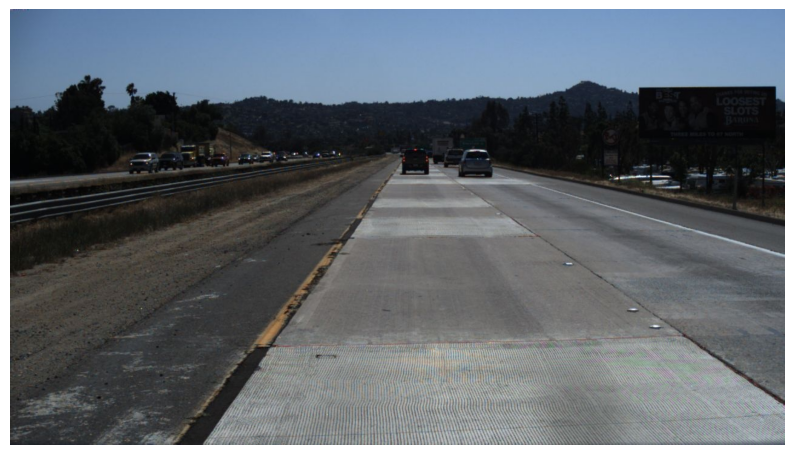

In [83]:
pair = random.choice(pairs_path)
# pair = (IMAGE_PATH, MASK_PATH)
print(f"Selected pair: {pair}")

original_image = cv2.imread(pair[0])
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

original_mask = cv2.imread(pair[1], cv2.IMREAD_GRAYSCALE)
original_mask = (original_mask >= 1).astype(np.uint8)

fig = plt.figure(figsize=(10, 10))
plt.imshow(original_image)
plt.axis('off')
plt.show()

In [84]:
IMAGE_SIZE = (256, 256 * 3) # (height, width)
PAD_DIVISOR = 32
AUGMENTATION_NAMES = ["blur", "noise", "dropout", "geometry", "color_invariance", "color_variation", "weather"]

train_transform = AlbumentationsTrainTransform(
    image_size=IMAGE_SIZE,
    pad_divisor=PAD_DIVISOR,
    augmentations=[],
    debug=True,
)

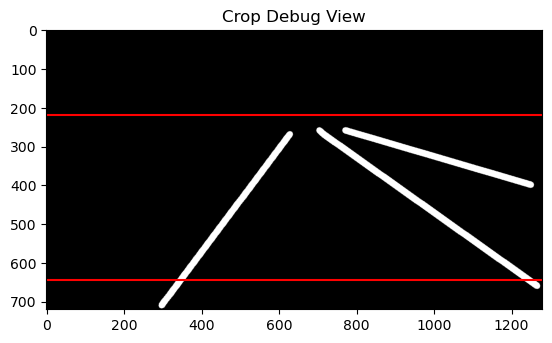

In [85]:
image, mask = train_transform(image=original_image, mask=original_mask)

In [86]:
train_image_np = train_transform.to_image(image)
train_mask_np = train_transform.to_mask(mask)

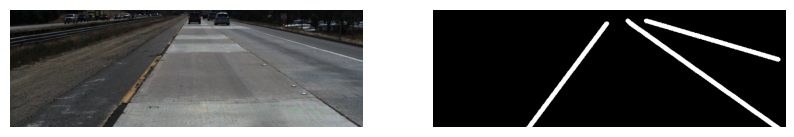

In [87]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(train_image_np)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(train_mask_np, cmap='gray')
plt.axis('off')
plt.show()

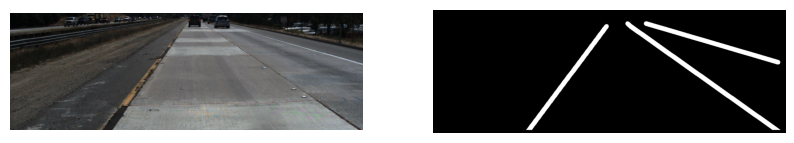

In [88]:
eval_transform = KorniaInferTransform(
    pad_divisor=PAD_DIVISOR,
    image_size=IMAGE_SIZE,
    debug=True,
)
image_tensor, infer_mask = eval_transform(image=original_image, mask=original_mask)

infer_image_np = eval_transform.to_image(image_tensor)
infer_mask_np = eval_transform.to_mask(infer_mask)

fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(infer_image_np)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(infer_mask_np, cmap='gray')
plt.axis('off')
plt.show()